In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Geometrical Shape and Sizing

In [2]:
# leaf spring shock absorber sizing
safety_factor = 1.5

# parameters in imperial for empirical equations
aircraft_weight = 1050
wing_area = 154.4
length = 2.5

theta = np.pi / 6

In [3]:
b = 0.0067 * (aircraft_weight * safety_factor) * np.sqrt((safety_factor * aircraft_weight/wing_area)) / (length * 12)

b

1.12344220999863

In [4]:
wb = 2.4
wr = 4.8
thickness = wr / 8

In [5]:
# dimensions in metric
print('Width root: ', np.round(wr*25.4, decimals=6), ' mm')
print('Width bottom: ', np.round(wb*25.4, decimals=6), ' mm')
print('Thickness: ', np.round(thickness*25.4, decimals=6), ' mm')

Width root:  121.92  mm
Width bottom:  60.96  mm
Thickness:  15.24  mm


<img src="images\img1.jpg" alt="Drawing" style="width: 500px;"/>

In [6]:
# SI units from now on
top_length = 0.762 + (0.05525/2 - 0.01524/2) - 0.020
bot_length = 0.14714 - 0.01524/2

# force encountered per landing gear
landing_force = (4.45*aircraft_weight * safety_factor) / 2

landing_force

3504.375

In [7]:
# stress analysis of curved beam
# parameters
curved_area = 0.06096 * 0.01524

# https://courses.washington.edu/me354a/Curved%20Beams.pdf
section_depth = 0.01524
outer_radius = 0.05524/2
inner_radius = outer_radius - section_depth

neutral_axis_radius = section_depth / (np.log(outer_radius/inner_radius))   # r
centroidal_axis_radius = inner_radius + section_depth / 2                   # r bar

In [8]:
# stress distributions of curved section
def inner_normal_stress(moment, loc):
    return (moment * loc) / (curved_area * (centroidal_axis_radius - neutral_axis_radius) * inner_radius)

def outer_normal_stress(moment, loc):
    return (moment * loc) / (curved_area * (centroidal_axis_radius - neutral_axis_radius) * outer_radius)

In [9]:
moment = 0.020 * landing_force
max_inner_stress = inner_normal_stress(moment, neutral_axis_radius - inner_radius)
max_outer_stress = outer_normal_stress(moment, outer_radius - neutral_axis_radius)

print('Maximum inner stress: ', np.round(max_inner_stress/1e6, decimals=2), ' MPa')
print('Maximum outer stress: ', np.round(max_outer_stress/1e6, decimals=2), ' MPa')

Maximum inner stress:  39.96  MPa
Maximum outer stress:  23.37  MPa


In [10]:
moment2 = 0.762 * landing_force
max_inner_stress2 = inner_normal_stress(moment2, neutral_axis_radius - inner_radius) - landing_force/9.290304e-4
max_outer_stress2 = outer_normal_stress(moment2, outer_radius - neutral_axis_radius) - landing_force/9.290304e-4

print('Maximum inner stress: ', np.round(max_inner_stress2/1e6, decimals=2), ' MPa')
print('Maximum outer stress: ', np.round(max_outer_stress2/1e6, decimals=2), ' MPa')

Maximum inner stress:  1518.58  MPa
Maximum outer stress:  886.72  MPa


## Stress Analysis Along Top Bar
Due to the taper, the stress in this area will vary

In [11]:
num_points = 250

x_vec = np.linspace(0, 0.742, num=num_points)
beam_width = np.linspace(0.06096, 0.12032, num=num_points)

shear = np.ones(num_points) * landing_force
moment = x_vec * landing_force

beam_inertia = (1/12) * beam_width * np.power(0.01524, 3)

beam_stress = (moment * 0.01524/2) / beam_inertia

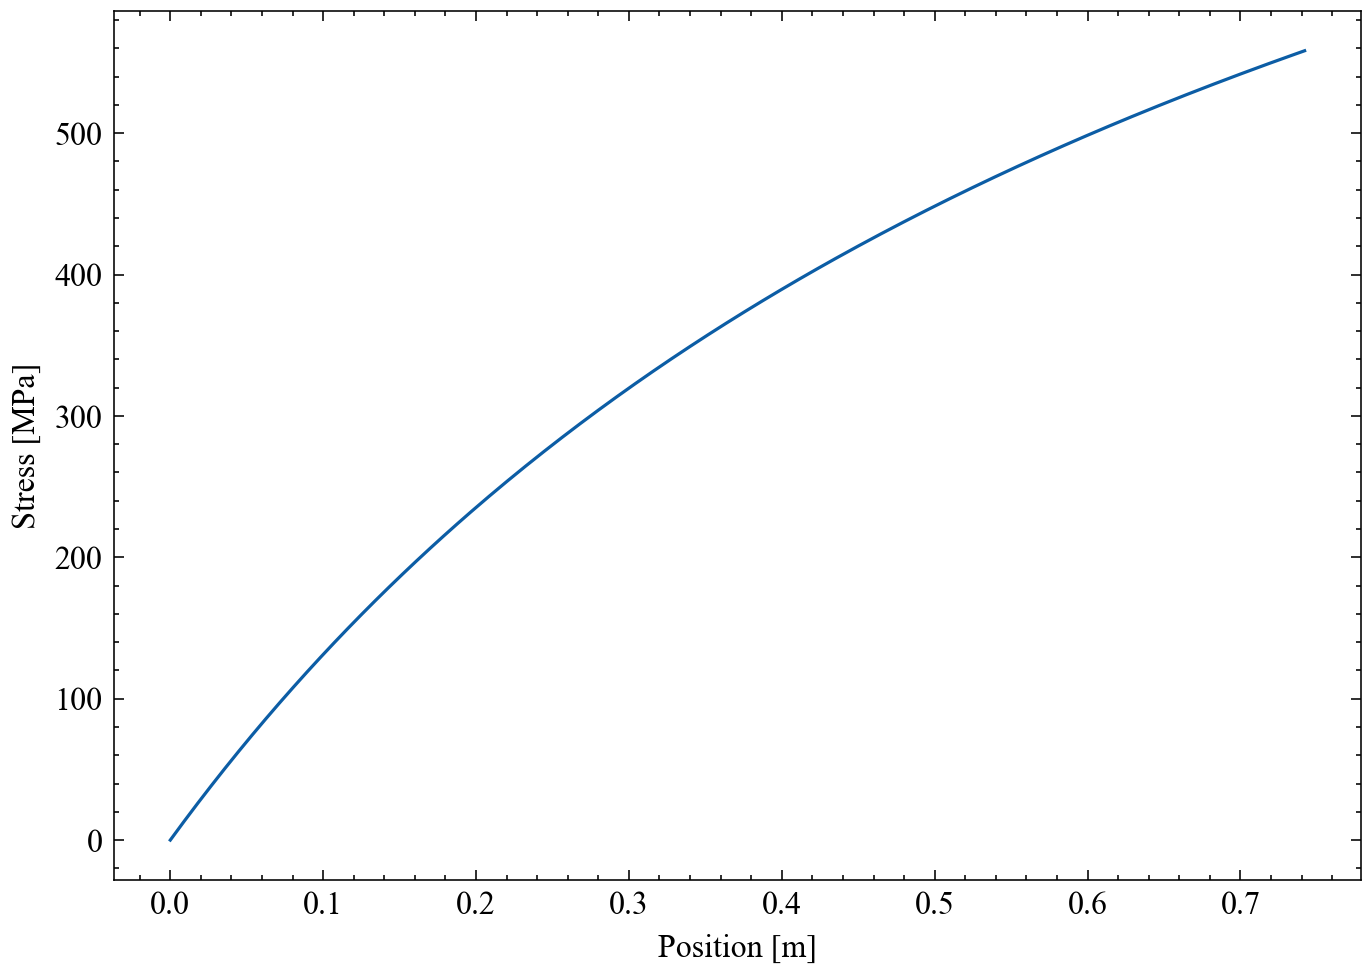

558.287587028964

In [12]:
plt.figure(dpi=230, figsize=(7,5))
plt.style.use(['science', 'no-latex'])

plt.plot(x_vec, beam_stress/1e6)

plt.xlabel('Position [m]')
plt.ylabel('Stress [MPa]')

plt.show()
max_beam_stress = beam_stress[-1]

max_beam_stress/1e6

## Material Selection

For a beam loaded in bending, optimizing for mass, the index is given as:
$$\displaystyle M = {(\phi_B^f \sigma_f)^{2/3} \over \rho} $$

For a rectangular cross section:
$$\displaystyle \phi_B^f = \sqrt{h / b} $$

Since the width of the beam is variable, the bending factor is evaluated at the point of greatest stress, when $b = 0.12032 \; \text{m}$.

$$\displaystyle \phi_B^f = \sqrt{h / b} = \sqrt{0.01524 / 0.12032} = 0.3559 $$

Thus the material index becomes
$$\displaystyle M = 0.5022{(\sigma_f)^{2/3} \over \rho}$$

In [13]:
bending_factor = np.sqrt(0.01524 / 0.12032)
max_stress = beam_stress[-1]/1e6

np.power(bending_factor, (2/3))

0.5022065599186758

Material chosen: Fatigue-Resistant 301 Stainless Steel

- https://www.azom.com/article.aspx?ArticleID=6558
- https://www.aksteel.com/sites/default/files/2018-01/301201706_0.pdf

In [14]:
mat_density = 7880
mat_yield = 758e6
mat_tensile = 1034e6

## Fatigue Analysis

In [15]:
load_factor = 1
grad_factor = 0.9
surf_factor = 0.78
temp_factor = 1
reli_factor = 1

endurance_limit = load_factor * grad_factor * surf_factor * temp_factor * reli_factor * 0.5*mat_tensile

print('Endurance limit: ', np.round(endurance_limit/1e6, decimals=2), ' Mpa')

Endurance limit:  362.93  Mpa


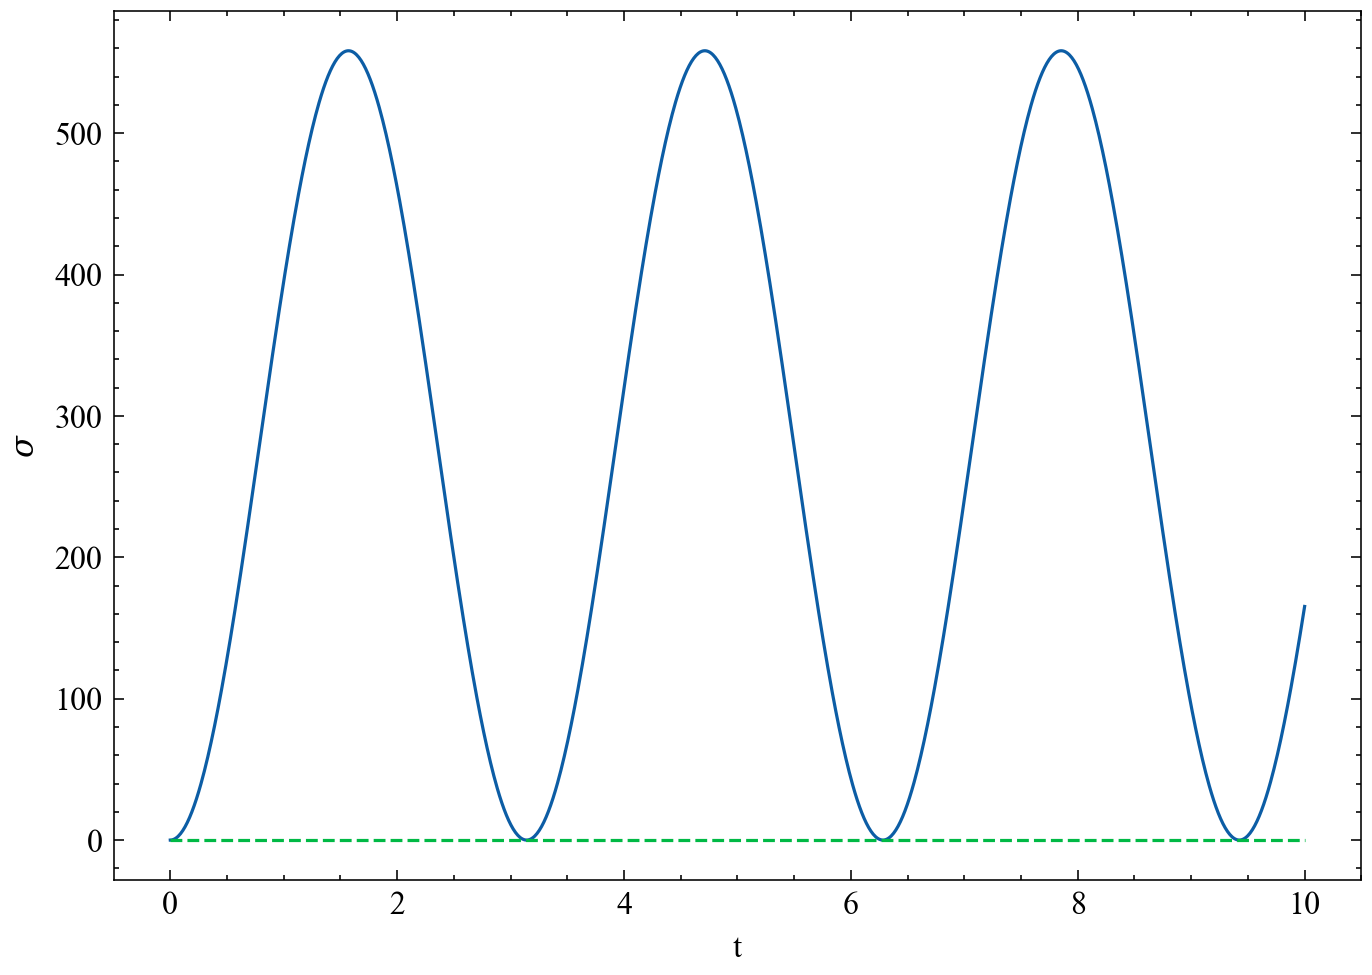

In [16]:
# modelling landing stresses on critical points
# attachment to plane
plt.figure(dpi=230, figsize=(7,5))
plt.style.use(['science', 'no-latex'])

t = np.linspace(0, 10, num=1000)

#sigma = (max_beam_stress/4) * np.exp(-0.5*t) * np.sin(3*t) + (max_beam_stress/4)
sigma = (max_beam_stress/(2*1e6))*np.cos(2*t + np.pi) + (max_beam_stress/(2*1e6))

plt.plot(t, sigma)
plt.plot([0, 10], [0, 0], linestyle='--')

plt.xlabel('t')
plt.ylabel(r'$\sigma$')
plt.show()

In [17]:
mean_stress = ((landing_force/1.5)/2)
max_stress = landing_force/1.5
min_stress = 0

stress_m = (max_stress + min_stress)/2
stress_a = (max_stress - min_stress)/2

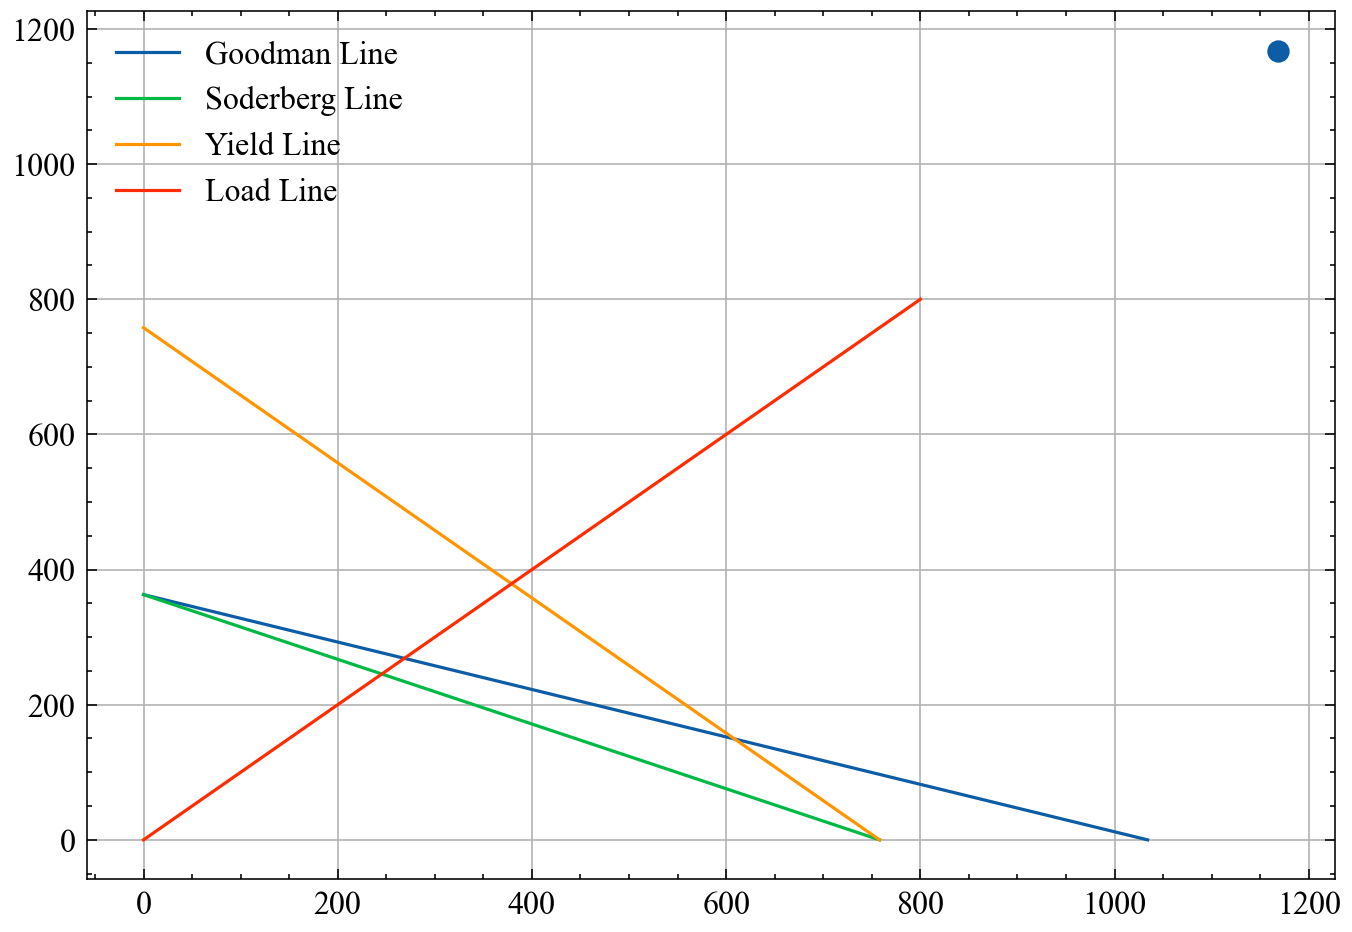

In [18]:
plt.figure(dpi=230, figsize=(7,5))
plt.style.use(['science', 'no-latex'])

plt.plot([0, mat_tensile/1e6], [endurance_limit/1e6, 0], label='Goodman Line')
plt.plot([0, mat_yield/1e6], [endurance_limit/1e6, 0], label='Soderberg Line')
plt.plot([0, mat_yield/1e6], [mat_yield/1e6, 0], label='Yield Line')

x = np.linspace(0,800)
y = (stress_a/stress_m)*x

plt.plot(x, y, label='Load Line')
plt.scatter(stress_a, stress_m)

plt.legend()
plt.grid()
plt.show()